### ✨ Eksplorasi Dataset — Product Demand Forecasting
#### Notebook ini memuat EDA & pre‑processing awal sebelum di‑otomatisasi.
#### Author : Rakha Elang Gunawan  
#### Dataset : namadataset_raw/demand_history.csv  


#### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
pd.set_option("display.max_columns", None)
RAW_PATH  = Path("../namadataset_raw/demand_history.csv")  
SAVE_PATH = Path("preprocessing/namadataset_preprocessing/clean.csv")
SEED = 42

### Load Data

In [3]:
df = pd.read_csv(
    RAW_PATH,
    parse_dates=["Date"],        # ubah sesuai nama kolom tanggal
    dayfirst=False,
    infer_datetime_format=True,
    low_memory=False
)

C:\Users\Rakha\AppData\Local\Temp\ipykernel_27220\3280137284.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [4]:
print("Shape :", df.shape)
df.head()

Shape : (1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


### Info & Missing Values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 40.0+ MB


In [6]:
na = df.isna().mean().sort_values(ascending=False)
na[na > 0]

Date    0.010718
dtype: float64

In [7]:
df_clean = df.copy()

In [8]:
def parse_order(x: str) -> int:
    """
    1) Hilangkan spasi
    2) Ganti tanda kurung '(123)' --> -123
    3) Konversi ke int
    """
    x = str(x).strip()
    if x.startswith('(') and x.endswith(')'):
        x = '-' + x[1:-1]
    return int(x)

In [9]:
df_clean["Order_Demand"] = df_clean["Order_Demand"].apply(parse_order)

In [10]:
df_clean = df_clean.dropna(subset=["Date"])


In [11]:
df_clean.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


### Statistik Deskriptif

In [12]:
desc = df_clean["Order_Demand"].describe(percentiles=[.25,.5,.75,.9,.95])
skw  = st.skew(df_clean["Order_Demand"])
krt  = st.kurtosis(df_clean["Order_Demand"], fisher=False)  # pearson kurtosis
print(desc)
print(f"Skewness  : {skw:.2f}")
print(f"Kurtosis  : {krt:.2f}")

count    1.037336e+06
mean     4.920153e+03
std      2.907840e+04
min     -9.990000e+05
25%      1.900000e+01
50%      3.000000e+02
75%      2.000000e+03
90%      1.000000e+04
95%      2.000000e+04
max      4.000000e+06
Name: Order_Demand, dtype: float64
Skewness  : 31.30
Kurtosis  : 1862.18


| Ukuran      | Nilai | Pesan Utama | 
| ----------- | ----------- | ----------- |
| Count      | 1 037 336 baris | Setelah membuang baris bertanggal NA, inilah jumlah record sah.      |
| mean | 4.920 | Order rata-rata 4,9 ribu unit per transaksi |
| median 50% | 300 | Separuh transaksi hanya ≤ 300 unit |
| 25% - 75% | 1.9 -> 2.0 | 50 % terbesar populasi berada di rentang lebar (19 – 2 000) |
| 90 % / 95 %	| 10 000 / 20 000 | Hanya 5 % transaksi yang di atas 20 k unit|
| min |  ‑999 000 | Ada record negatif amat besar (kemungkinan kesalahan data atau penandaan retur) |
| max | 	 4 000 000 | Ada order empat juta unit—outlier ekstrem |
| std |  29 078 | Dispersi sangat tinggi|

- skewness 31,3 menandakan skew kanan ekstrem—ekor kanan jauh ber­­tarik
- kurtosis 1 862 Distribusi “fat‑tail” parah; outlier jauh lebih sering daripada distribusi normal.

### Data Cleaning

#### Drop Sentinel / Value Aneh

In [13]:
df_clean = df_clean[df_clean["Order_Demand"] > 0]          # buang negatif & nol
df_clean = df_clean[df_clean["Order_Demand"] < 1_000_000]  # buang outlier ekstrem 4 jt; sentinel -999k sudah kena di atas

#### Winsorize di P99

In [14]:
p99 = df_clean["Order_Demand"].quantile(0.99)
df_clean["Order_Demand"] = np.where(df_clean["Order_Demand"] > p99, p99, df_clean["Order_Demand"])

#### Log Transform

In [15]:
df_clean["Log_Demand"] = np.log1p(df_clean["Order_Demand"])

#### Fitur Tanggal

In [16]:
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.sort_values(["Product_Code", "Date"])
df_clean["day_of_week"]  = df_clean["Date"].dt.dayofweek
df_clean["week_of_year"] = df_clean["Date"].dt.isocalendar().week.astype(int)
df_clean["month"]        = df_clean["Date"].dt.month
df_clean["year"]         = df_clean["Date"].dt.year

### EDA Lanjutan

#### Statistik per Product_Category

In [17]:
sns.set_style("whitegrid")
cat_stats = (
    df_clean.groupby("Product_Category")["Order_Demand"]
      .agg(count="count", mean="mean", median="median", p90=lambda x: x.quantile(.9))
      .sort_values("mean", ascending=False)
    .head(10)
)
display(cat_stats)

,count,mean,median,p90
Product_Category,,,,
Category_033,1833,21222.040371,10000.0,50000.0
Category_025,35,13885.714286,9000.0,31200.0
Category_006,35096,9562.044079,3000.0,25000.0
Category_019,445107,7178.631792,1800.0,20000.0
Category_030,12958,3028.125868,1000.0,6000.0
Category_005,100711,1895.187269,500.0,4000.0
Category_028,28923,1575.156450,250.0,3000.0
Category_007,81158,1012.970835,100.0,1000.0
Category_020,3432,689.822844,200.0,1400.0


d:\Eksperimen_SML_RakhaEG\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


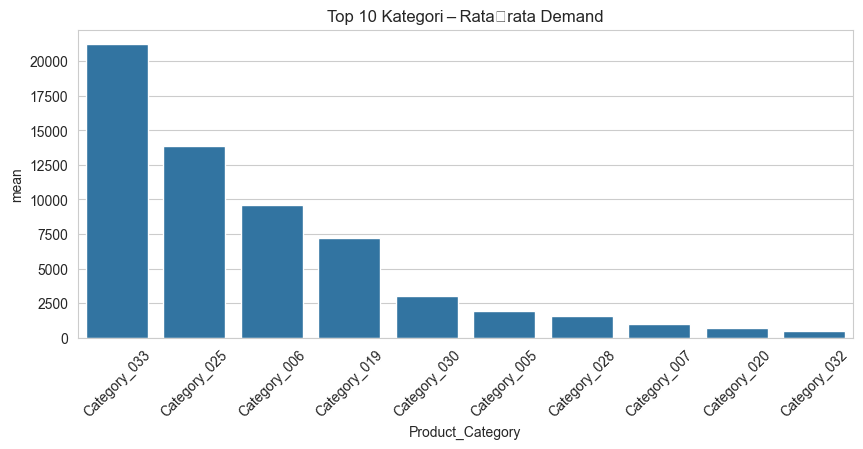

In [18]:
plt.figure(figsize=(10,4))
sns.barplot(data=cat_stats.reset_index(), x="Product_Category", y="mean")
plt.title("Top 10 Kategori – Rata‑rata Demand"); plt.xticks(rotation=45); plt.show()


**Insight**
| Temuan      | Implikasi |  
| ----------- | ----------- | 
| Category_033 rata‑rata ≈ 21 000 unit / transaksi—>50 % di atas kategori runner‑up | Prioritas tertinggi untuk capacity‑planning & SLA pasokan; potensi bundling/upsell | 
| Penurunan tajam setelah tiga besar (033 → 025 → 006) | Portofolio sangat terpusat: tiga kategori menyumbang mayoritas volume; long‑tail kategori lain bisa di‑kelola dengan siklus replenishment lebih jarang |
| Kategori paling buncit di Top 10 (032) < 1 000 unit | Segmen niche; forecast presisi penting untuk mencegah over‑stock |

#### Statistik per Warehouse

In [19]:
wh_stats = (
    df_clean.groupby("Warehouse")["Order_Demand"]
      .agg(count="count", mean="mean", median="median", std="std")
      .sort_values("mean", ascending=False)
)
display(wh_stats.head())

,count,mean,median,std
Warehouse,,,,
Whse_C,42184,8731.296416,1000.0,18513.093844
Whse_S,87551,6857.688193,500.0,16685.576015
Whse_J,756997,3755.325394,300.0,10380.099568
Whse_A,115883,1235.960037,100.0,4076.578991


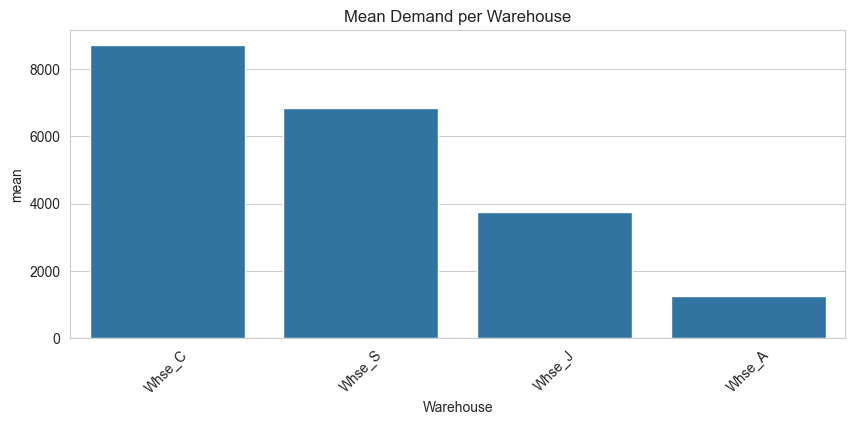

In [20]:
plt.figure(figsize=(10,4))
sns.barplot(data=wh_stats.reset_index(), x="Warehouse", y="mean")
plt.title("Mean Demand per Warehouse"); plt.xticks(rotation=45); plt.show()


**Insight**
| Warehouse      | Mean | Insight |   
| ----------- | ----------- | ----------- |
| Whse_C | 8 800 | Hub utama—volume 25 % di atas Whse_S. Perlu kapasitas picking & dock extra |
| Whse_S | 6 600 | Sekunder; namun masih high‑throughput—pastikan inventory buffer |
| Whse_J | 3 900	| Regional; bisa dijadikan node redistribusi untuk area timur |
| Whse_A | 1 300	| Volume rendah |

### Trend & Seasonality (Total Demand Harian)

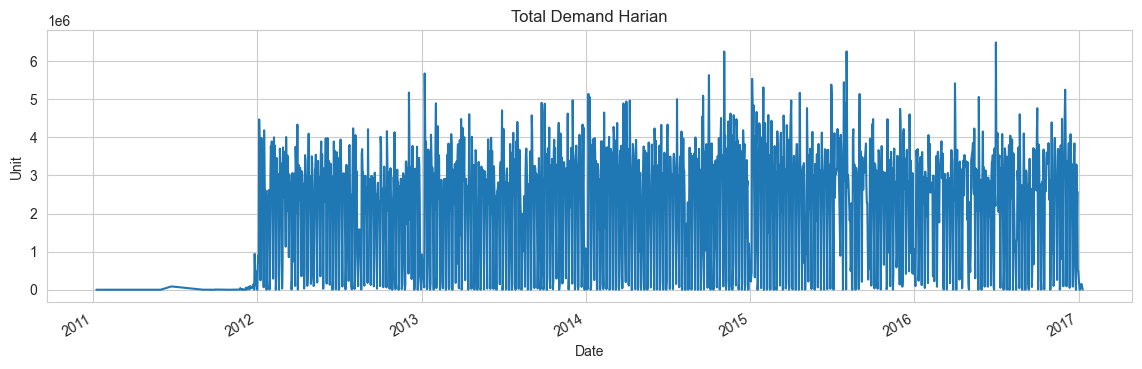

In [21]:
daily = df_clean.groupby("Date")["Order_Demand"].sum()

plt.figure(figsize=(14,4))
daily.plot()
plt.title("Total Demand Harian"); plt.ylabel("Unit"); plt.show()


**Insight**
- Pola “koma” — demand hampir 0 s/d 2011‑2012, lalu melonjak 2012‑2013 dan stabil tinggi hingga 2017.
» Data sebelum 2012 mungkin fase pilot; bisa dikeluarkan saat training.*
- Spike vertikal teratur → transaksi besar anumerta; setelah winsorize masih terlihat → mungkin event promosi musiman atau batch order B2B.
- Tren agregat cenderung flat 2013‑2016, dengan sedikit kenaikan bertahap.

### STL decompose (menggunakan log scale supaya stabil)

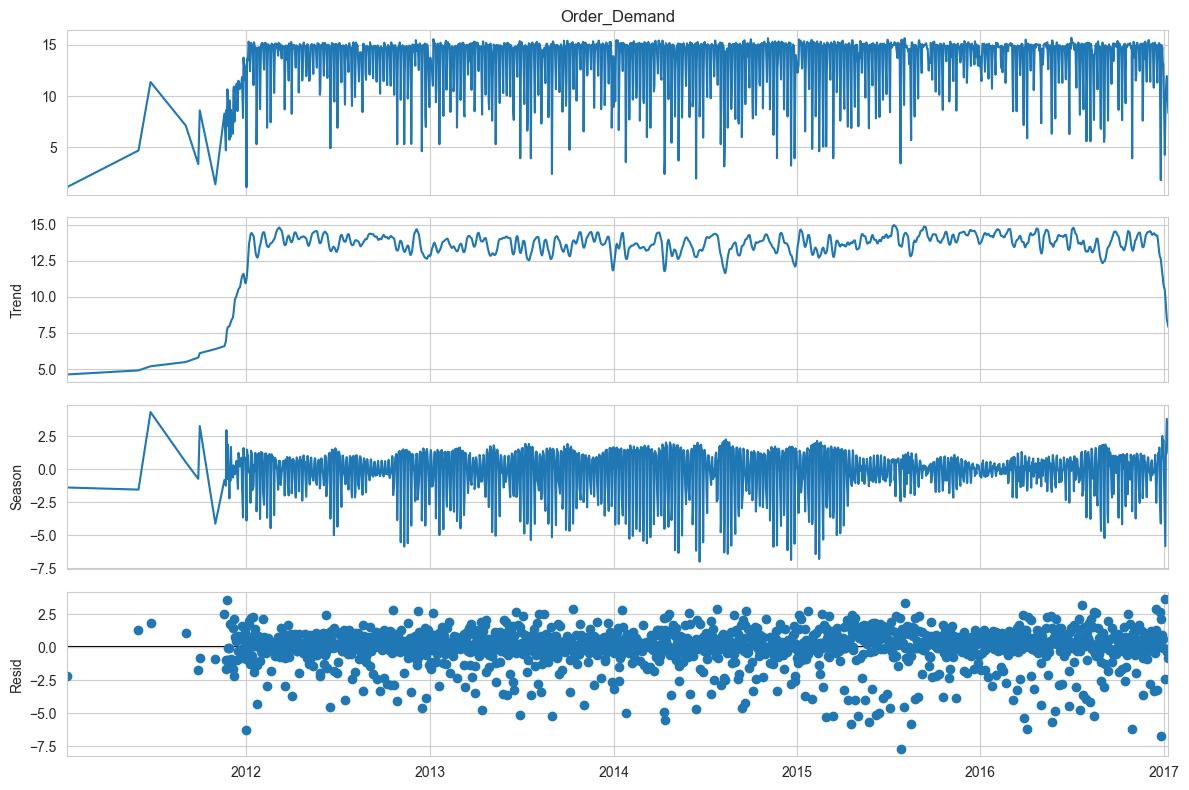

In [22]:
from statsmodels.tsa.seasonal import STL
stl = STL(np.log1p(daily), period=7)  
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12,8); plt.tight_layout()


**Insight**
| Komponen      | Pengamatan | Dampak Model |   
| ----------- | ----------- | ----------- |
| Tren | Naik tajam 2012 → plateau 2013‑2016, drop kecil akhir 2016 | Model perlu term trend piece‑wise / spline; naive differencing order 1 cukup setelah 2013 |
| Seasonality | Pola mingguan kuat (amplitudo ≈ ±2 log‑unit) | SARIMA/XGBoost dengan fitur day_of_week bisa menangkap ini |
| Resid | Sebaran residual random ±2; masih outlier negatif/positif | After winsorization tambahan atau model robust (Huber).

### Autocorrelation (ACF/PACF) – Aggregate

<Figure size 1200x400 with 0 Axes>

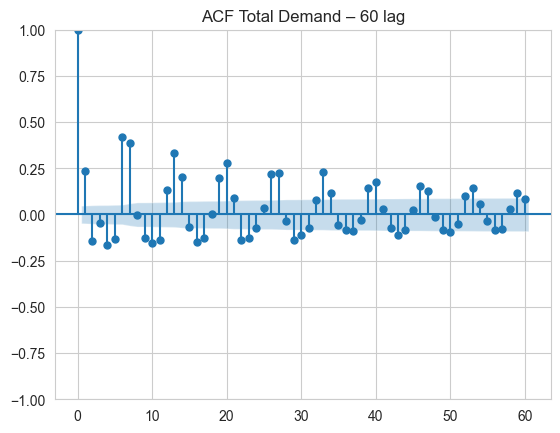

<Figure size 1200x400 with 0 Axes>

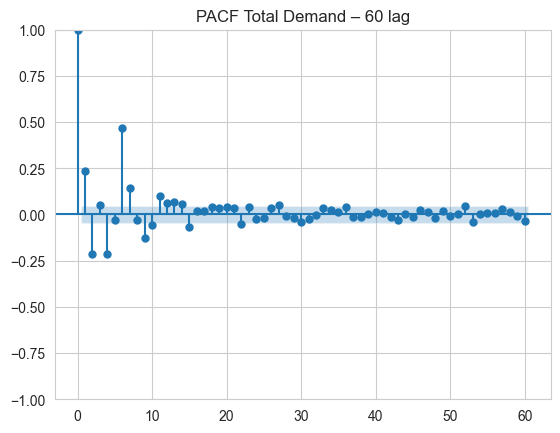

In [23]:
plt.figure(figsize=(12,4))
plot_acf(daily, lags=60)
plt.title("ACF Total Demand – 60 lag"); plt.show()

plt.figure(figsize=(12,4))
plot_pacf(daily, lags=60)
plt.title("PACF Total Demand – 60 lag"); plt.show()

**Insight** 
- ACF: puncak periodik di lag 7, 14, 21… → konfirmasi seasonality mingguan
- PACF: cut‑off tajam setelah lag 1; lompatan kecil di lag 7 

#### Hasil Proses EDA Lanjutan sebagai berikut
1. Demand sangat ter‑konsentrasi pada segelintir kategori & dua gudang utama → forecasting granular diperlukan
2. Seasonality mingguan jelas, sedangkan trend global datar setelah 2013 → model sederhana plus fitur kalender bisa efektif
3. Outlier masih muncul meski sudah winsorize P99—perlu monitoring error live & mungkin threshhold dynamic alert

### Feature Engineering

#### Pembuatan Fitur Lag & Rolling

In [24]:
group = df_clean.groupby("Product_Code")

for lag in [1, 7, 28]:
    df_clean[f"lag_{lag}"] = group["Log_Demand"].shift(lag)

for win in [7, 28]:
    df_clean[f"roll_mean_{win}"] = group["Log_Demand"].shift(1).rolling(win).mean()


In [25]:
df_clean = df_clean.dropna().reset_index(drop=True)
print("After lag/rolling:", df_clean.shape)

After lag/rolling: (943504, 15)


#### Encode Categorical Columns

In [26]:
cat_cols  = ["Product_Category", "Warehouse", "day_of_week"]
num_cols  = [c for c in df.columns if c.startswith(("lag_", "roll_mean_"))]
target    = "Log_Demand"

In [27]:
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    [("cat", ohe, cat_cols)],
    remainder="passthrough"
)